In [1]:
import MilneEddington 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
#Load the data
stokes = fits.open('/home/milic/data/Hinode_network/hinode_network_c.fits')[0].data

In [3]:
qs = np.mean(stokes[:,:,0,:10])
stokes /= qs
stokes.shape

(512, 873, 4, 112)

In [4]:
# Let's also assign wavelengths:
ll = np.linspace(0,111,112)
ll = 6302.08 + (ll-56.5)*0.0215
regions = [[ll, None]]
lines   = [6301, 6302]
# so now our code has wavelength grid and knows what to do

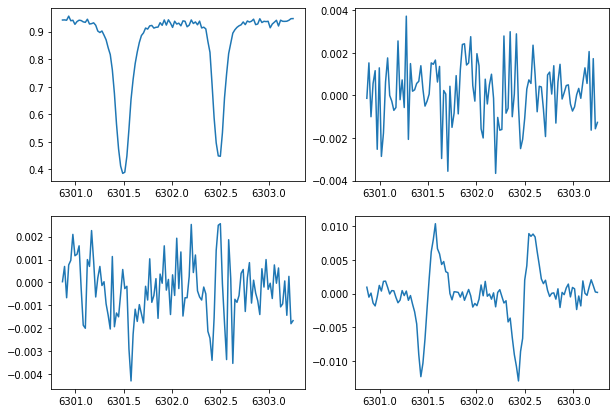

In [5]:
i=100
j=200
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,stokes[i,j,0])
plt.subplot(222)
plt.plot(ll,stokes[i,j,1])
plt.subplot(223)
plt.plot(ll,stokes[i,j,2])
plt.subplot(224)
plt.plot(ll,stokes[i,j,3])

In [6]:
#initialize the methods:
me = MilneEddington.MilneEddington(regions, lines, nthreads=1)

In [7]:
# set up noise etc
noise_level = 1.e-3
sig = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
sig += noise_level
sig[0] *= 10. #noise is larger for I, because of systematics

In [12]:
nx = 1
ny = 1
iGuessed = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
guessed_initial  = me.repeat_model(iGuessed, nx, ny)
to_fit = stokes[i,j].reshape(1,1,4,112)
    
#
# This is where the inversion happens:
#
model_out, syn_out, chi2 = me.invert(guessed_initial, to_fit, sig, nRandom = 20, nIter=100, chi2_thres=1.0, verbose=False)


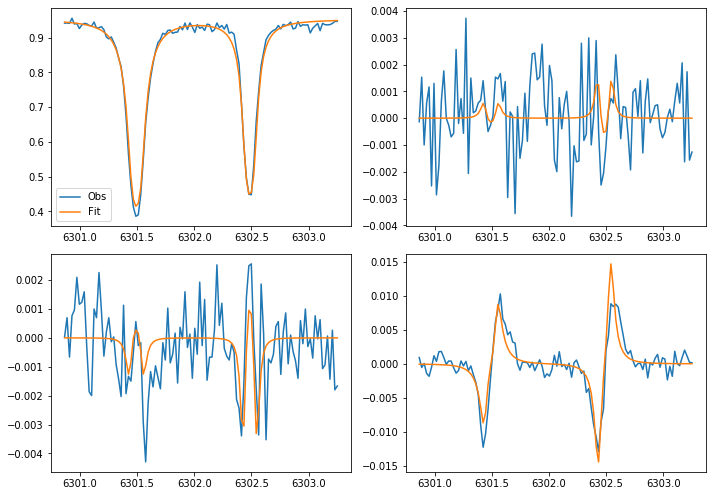

In [13]:
#test the plot
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,to_fit[0,0,0],label='Obs')
plt.plot(ll,syn_out[0,0,0],label='Fit')
plt.legend()
plt.subplot(222)
plt.plot(ll,to_fit[0,0,1],label='Obs')
plt.plot(ll,syn_out[0,0,1],label='Fit')
plt.subplot(223)
plt.plot(ll,to_fit[0,0,2],label='Obs')
plt.plot(ll,syn_out[0,0,2],label='Fit')
plt.subplot(224)
plt.plot(ll,to_fit[0,0,3],label='Obs')
plt.plot(ll,syn_out[0,0,3],label='Fit')
plt.tight_layout()

In [14]:
# Now we will try the same but for a chunk of pixels, re-alloc something:
me = MilneEddington.MilneEddington(regions, lines, nthreads=8)

pyMilne::dealloc: cleaning-up...


In [15]:
%%time
i = 0
j = 0
nx = 512
ny = 873
iGuessed = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
guessed_initial  = me.repeat_model(iGuessed, nx, ny)
to_fit = stokes[i:i+nx,j:j+ny].reshape(nx,ny,4,112)
    
#
# This is where the inversion happens:
#
model_out, syn_out, chi2 = me.invert(guessed_initial, to_fit, sig, nRandom = 10, nIter=50, chi2_thres=1.0, verbose=False)

CPU times: user 3h 53min 8s, sys: 39.2 s, total: 3h 53min 47s
Wall time: 32min 46s


In [87]:
print(chi2)

[[2.29728036 1.73825511 1.58840363 ... 1.66840515 1.73261224 1.48439762]
 [2.30997283 1.73825511 1.59437112 ... 1.65333571 1.72248521 1.46067309]
 [2.30083603 1.73724805 1.58619916 ... 1.67129161 1.72637478 1.45949974]
 ...
 [1.63960582 1.57674175 1.61337078 ... 2.25312074 1.9294753  1.75910688]
 [1.81141317 1.54223223 1.63699113 ... 1.77138933 2.13767483 1.89890694]
 [1.74662752 1.30382468 1.42490021 ... 1.83437726 1.77476884 2.02761639]]


In [94]:
model_out.shape
#model_out = model_out.reshape(nx,ny,9)

(512, 873, 9)

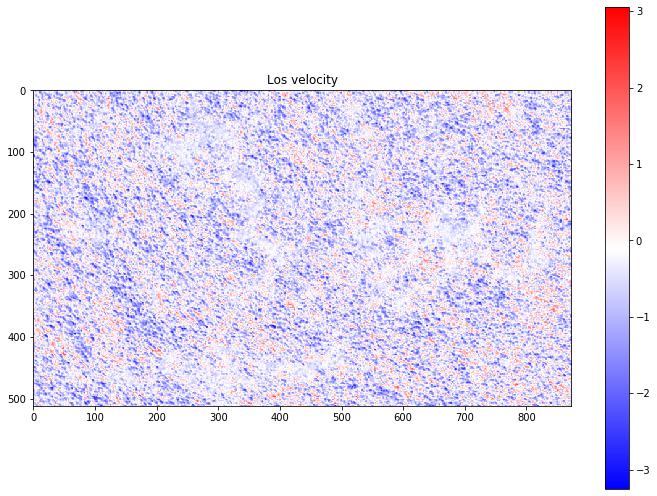

In [98]:
# Numbers look good, now let's try and plot some parameter maps:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,3],cmap='bwr',origin='lower')
plt.title("Los velocity")
plt.colorbar()
plt.tight_layout()

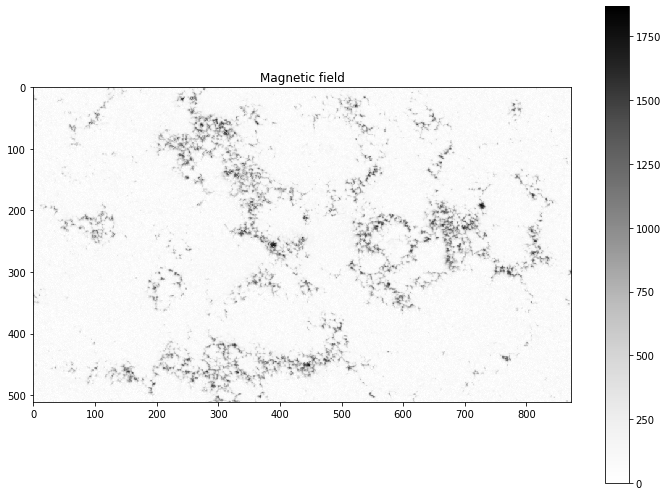

In [96]:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,0],cmap='Greys',origin='lower')
plt.title("Magnetic field")
plt.colorbar()
plt.tight_layout()

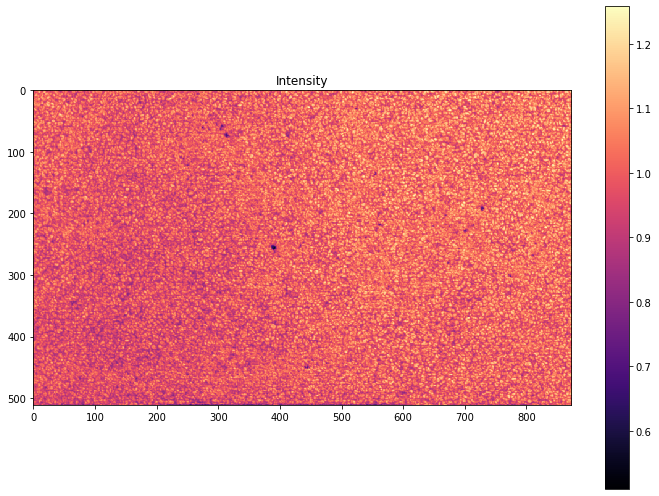

In [97]:
plt.figure(figsize=[10,7])
plt.imshow(stokes[:,:,0,0],cmap='magma')
plt.title("Intensity")
plt.colorbar()
plt.tight_layout()